In [32]:
import kaggle
import os
import numpy as np
import zipfile
import pandas as pd
import seaborn as sns
import pickle
from datetime import datetime
from sklearn.model_selection import RepeatedKFold, cross_validate, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, SCORERS
from math import sqrt

In [93]:
def submit_to_kaggle(predictions):
    submission_time = "{:%Y_%m_%d_%H_%M_%S}".format(datetime.now())
    predictions.to_csv("submissions/rfr_%f_%s.csv" % (sqrt(-clf.best_score_),submission_time),index=False)
    submission_file_path = os.path.abspath("submissions/rfr_%f_%s.csv" % (sqrt(-clf.best_score_),submission_time))
    submission = kaggle_api.competition_submit(competition=COMPETITION_NAME,
                                               file_name=submission_file_path,
                                               message="rfr_%f_%s" % (sqrt(-clf.best_score_),submission_time))
    print(submission)
    
def save_best_model(clf, model_name, model_version, completion_time):
    model_file_path = 'models/%s_v%i_%f_%s.model' % (model_name, model_version, sqrt(-clf.best_score_), completion_time)
    pickle.dump(clf.best_estimator_,open(model_file_path, 'wb'))
    
    pd.DataFrame(clf.cv_results_).to_csv('models/%s_v%i_%f_%s.csv' % (model_name, model_version, sqrt(-clf.best_score_), completion_time),
                                        index=False)
    
def build_model(model, model_name, model_version, parameter_grid, cross_validation, train, y_train):
    clf = GridSearchCV(estimator = model,
                          param_grid = parameter_grid,
                          scoring = 'neg_mean_squared_error',
                          n_jobs=-1,
                          iid=False,
                          cv=cross_validation,
                          return_train_score=True,
                          verbose=3)
    clf.fit(X = train,
            y = y_train)
    completion_time = "{:%Y_%m_%d_%H_%M_%S}".format(datetime.now())
    
    best_score = sqrt(-clf.best_score_)    
    save_best_model(clf, model_name, model_version, completion_time)
    
    print("Model completion time: %s" % completion_time)
    print("Best cross validation score: %f" % best_score)
    print("Best parameters: %s" % clf.best_params_)
    
    return {
        "model": model,
        "model_name": model_name,
        "model_version": model_version,
        "best_parameters": clf.best_params_,
        "best_score": best_score,
        "cv_results": pd.DataFrame(clf.cv_results_)
    } 


In [4]:
# Download data
COMPETITION_NAME = 'elo-merchant-category-recommendation'
DOWNLOAD_FILES = False
UNZIP_FILES = False

kaggle_api = kaggle.KaggleApi()
kaggle_api.authenticate()

if DOWNLOAD_FILES:
    kaggle_api.competition_download_files(competition=COMPETITION_NAME, path='data', quiet=False)

if UNZIP_FILES:
    for item in os.listdir('data',):
        if item.endswith('zip'):
            file_name = os.path.abspath('data/' + item)
            zip_ref = zipfile.ZipFile(file_name)
            zip_ref.extractall('data/')
            zip_ref.close()
            os.remove(file_name)

In [5]:
# Read data
merchants = pd.read_csv('data/merchants.csv')
new_trans = pd.read_csv('data/new_merchant_transactions.csv')
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')
hist_trans = pd.read_csv('data/historical_transactions.csv')

## Data manipulation

In [41]:
train['first_active_year'] = train.first_active_month.str[:4]
train['first_active_month_m'] = train.first_active_month.str[5:].astype('int')

test['first_active_month'].fillna('2017-06',inplace=True)
test['first_active_year'] = test.first_active_month.str[:4]
test['first_active_month_m'] = test.first_active_month.str[5:].astype('int')

## Explore train

In [42]:
train.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'target', 'first_active_year', 'first_active_month_m'],
      dtype='object')

In [43]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,first_active_year,first_active_month_m
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,2017,6
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,2017,1
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,2016,8
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,2017,9
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,2017,11


In [44]:
test.iloc[11578]

first_active_month              2017-06
card_id                 C_ID_c27b4f80f7
feature_1                             5
feature_2                             2
feature_3                             1
first_active_year                  2017
first_active_month_m                  6
Name: 11578, dtype: object

In [45]:
test[test.isnull().any(axis=1)]

,first_active_month,card_id,feature_1,feature_2,feature_3,first_active_year,first_active_month_m


#### target

In [46]:
train.target.describe()

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

In [47]:
train.groupby(pd.cut(train.target,[-40,-1,0,1,40])).agg('size')

target
(-40, -1]    45742
(-1, 0]      58566
(0, 1]       56709
(1, 40]      40900
dtype: int64

/Users/scobra/anaconda/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


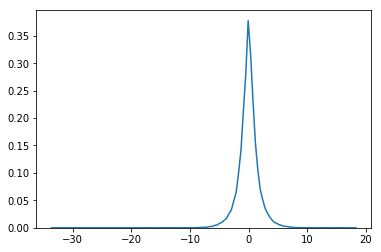

In [48]:
ax = sns.distplot(train[['target']], hist=False,rug = False)

Is normally distributed, half of data is between -1 and 1

#### first_active_month

In [49]:
print(train.first_active_month.min())
print(train.first_active_month.max())

2011-11
2018-02


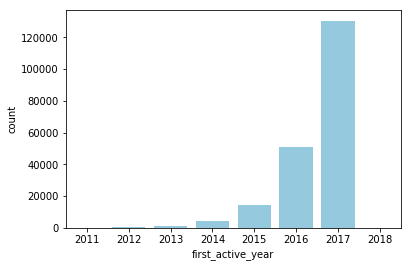

In [50]:
sns.countplot(x='first_active_year', data=train, color='skyblue')

[(-2.5, 2.5)]

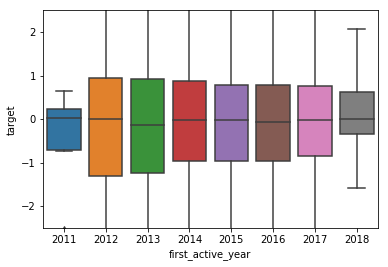

In [51]:
ax = sns.boxplot(x='first_active_year',y='target',data=train,orient='v')
ax.axes.set(ylim=(-2.5,2.5))

#### first_active_month_m

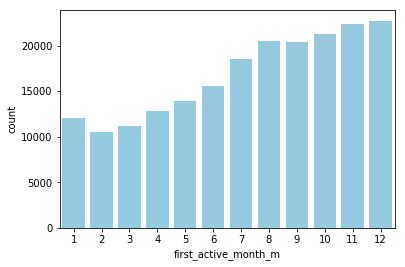

In [52]:
sns.countplot(x='first_active_month_m', data=train, color='skyblue')

In [53]:
year_months = train.groupby(['first_active_year','first_active_month_m']).size()
year_months.groupby('first_active_year').apply(lambda x: 100*x/x.sum()).groupby('first_active_month_m').mean()

first_active_month_m
1     19.471427
2      3.731123
3      4.763369
4      6.154659
5      7.960435
6      7.462820
7      9.419159
8     10.438816
9     10.586543
10    10.746234
11    22.075000
12    13.905195
dtype: float64

#### feature_1

In [54]:
temp = train.groupby('feature_1').size().reset_index(name='count')
temp['proportion'] = temp['count']/temp['count'].sum()
temp

,feature_1,count,proportion
0,1,12037,0.059614
1,2,55797,0.276336
2,3,73573,0.364372
3,4,19885,0.098481
4,5,40625,0.201197


[(-10, 10)]

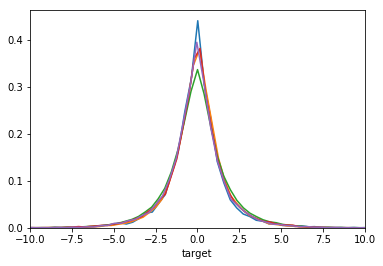

In [55]:
sns.distplot(train[train.feature_1==1].target, hist=False)
sns.distplot(train[train.feature_1==2].target, hist=False)
sns.distplot(train[train.feature_1==3].target, hist=False)
sns.distplot(train[train.feature_1==4].target, hist=False)
sns.distplot(train[train.feature_1==5].target, hist=False).set(xlim=[-10,10])

In [56]:
train.groupby('feature_1').target.agg('describe')

,count,mean,std,min,25%,50%,75%,max
feature_1,,,,,,,,
1,12037.0,-0.315476,3.407106,-33.219281,-0.810411,-0.011003,0.666923,15.011358
2,55797.0,-0.350452,3.756032,-33.219281,-0.806444,0.000000,0.768908,13.592223
3,73573.0,-0.377533,3.834499,-33.219281,-0.956521,-0.036539,0.837927,15.606405
4,19885.0,-0.404652,3.817954,-33.219281,-0.856211,0.000000,0.728345,9.665204
5,40625.0,-0.499879,4.134833,-33.219281,-0.895946,-0.056208,0.692869,17.965068


#### feature_2

In [57]:
temp = train.groupby('feature_2').target.agg('describe').reset_index()
temp['count_proportion'] = temp['count']/sum(temp['count'])
temp

,feature_2,count,mean,std,min,25%,50%,75%,max,count_proportion
0,1,89242.0,-0.398675,3.890548,-33.219281,-0.822850,-0.002394,0.738072,17.965068,0.441974
1,2,74839.0,-0.332899,3.567683,-33.219281,-0.946076,-0.045086,0.799371,15.606405,0.370642
2,3,37836.0,-0.501889,4.269270,-33.219281,-0.902546,-0.033784,0.766570,13.350895,0.187384


#### feature_3

In [58]:
train.groupby('feature_3').target.agg('describe').reset_index()

,feature_3,count,mean,std,min,25%,50%,75%,max
0,0,87719.0,-0.357939,3.724459,-33.219281,-0.817775,0.000000,0.745114,15.011358
1,1,114198.0,-0.421057,3.944379,-33.219281,-0.934403,-0.044637,0.783653,17.965068


### Build models

In [69]:
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=11)

In [94]:
rfr_params = {
    'max_depth':[2,3,4,5,6]
}
results = build_model(model = RandomForestRegressor(random_state=11,n_estimators=100),
            model_name = "random_forest", 
            model_version = 1,
            parameter_grid = rfr_params,
            cross_validation = rkf, 
            train = train.drop(['target','card_id','first_active_month'],axis=1),
            y_train = train.target)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   31.2s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   37.4s finished


Model completion time: 2019_01_22_14_36_12
Best cross validation score: 3.841844
Best parameters: {'max_depth': 5}


In [95]:
results['cv_results']

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,5.255696,0.065997,0.164867,0.009109,2,{'max_depth': 2},-15.274200,-14.538711,-15.094506,-14.512329,...,-14.768794,0.346111,5,-14.640677,-14.823503,-14.685425,-14.830786,-14.853449,-14.766768,0.086425
1,7.288346,0.046149,0.205020,0.017967,3,{'max_depth': 3},-15.265718,-14.533152,-15.087843,-14.506218,...,-14.761152,0.346300,3,-14.632307,-14.813679,-14.674756,-14.820312,-14.843899,-14.756991,0.086122
2,9.710016,0.546963,0.287831,0.058596,4,{'max_depth': 4},-15.263671,-14.532514,-15.087630,-14.504791,...,-14.760063,0.346183,2,-14.625404,-14.805766,-14.666203,-14.813079,-14.836050,-14.749300,0.086066
3,12.932880,0.684623,0.264854,0.010766,5,{'max_depth': 5},-15.260013,-14.531805,-15.087817,-14.505445,...,-14.759763,0.344745,1,-14.616528,-14.795519,-14.655802,-14.804243,-14.826073,-14.739633,0.085967
4,11.401343,2.378382,0.228571,0.019825,6,{'max_depth': 6},-15.260377,-14.536240,-15.090407,-14.508931,...,-14.762483,0.343697,4,-14.606561,-14.782843,-14.643854,-14.793548,-14.814493,-14.728260,0.085572


In [61]:
clf.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=11, verbose=0, warm_start=False)

#### Fit best estimator model to test set

In [41]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,first_active_year,0,first_active_month_m
0,2017-04,C_ID_0ab67a22ab,3,3,1,2017,NaN,4
1,2017-01,C_ID_130fd0cbdd,2,3,0,2017,NaN,1
2,2017-08,C_ID_b709037bc5,5,1,1,2017,NaN,8
3,2017-12,C_ID_d27d835a9f,2,1,0,2017,NaN,12
4,2015-12,C_ID_2b5e3df5c2,5,1,1,2015,NaN,12


In [139]:
predictions = pd.Series(clf.best_estimator_.predict(test.drop(['card_id','first_active_month'],axis=1)))
test_predictions = pd.concat([test.card_id,predictions],axis=1)
test_predictions.rename(columns={0:'target'},inplace=True)

In [146]:
submit_to_kaggle(test_predictions)

100%|██████████| 4.30M/4.30M [00:03<00:00, 1.15MB/s]


Successfully submitted to Elo Merchant Category Recommendation


In [147]:
kaggle_api.competition_submissions_cli(competition=COMPETITION_NAME)

fileName                              date                 description                       status    publicScore  privateScore  
------------------------------------  -------------------  --------------------------------  --------  -----------  ------------  
rfr_3.841905_2019_01_22_08_57_13.csv  2019-01-22 08:57:18  rfr_3.841905_2019_01_22_08_57_13  complete  3.921        None          
rfr_3.841905_2019_01_22_08_53_14.csv  2019-01-22 08:53:18  rfr_3.841905_2019_01_22_08_53_14  complete  3.921        None          
rfr_3.841905_2019_01_22_08_51_48.csv  2019-01-22 08:51:53  rfr_3.841905_2019_01_22_08_51_48  error     None         None          
rfr_3.841905_2019_01_22_08_46_16.csv  2019-01-22 08:46:21  rfr_3.841905_2019_01_22_08_46_16  error     None         None          
